# Zero-Shot prompt-based 3D shape extraction of specific object from unlabeled 2D Images


Mount drive for processing files

In [ ]:
# Please add the shared folder to your drive and mount it here.
# Link: https://drive.google.com/drive/folders/1RF1tMwIdm1KmmpnEy-YbA7-5bwQeyBWj?usp=sharing

from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = '3DCloudCreationProject' # Update path to the project folder shared above

import sys
# Update paths as needed
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/3DCloudCreationProject


Install YOLOWorld

In [ ]:
# Install packages
!pip install ultralytics
import ultralytics
ultralytics.checks()
from ultralytics import YOLOWorld
model = YOLOWorld("yolov8s-world.pt")

Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 21.2/107.7 GB disk)


In [ ]:
# Setup YOLOWorld Model
from ultralytics import YOLOWorld
model = YOLOWorld("yolov8s-world.pt")
device = "cuda" if torch.cuda.is_available() else "cpu"

Test images showing zero-shot detection







image 1/1 /content/drive/My Drive/3DCloudCreationProject/bus.jpg: 640x480 5 persons, 1 bus, 1 stop sign, 760.0ms
Speed: 13.0ms preprocess, 760.0ms inference, 28.0ms postprocess per image at shape (1, 3, 640, 480)


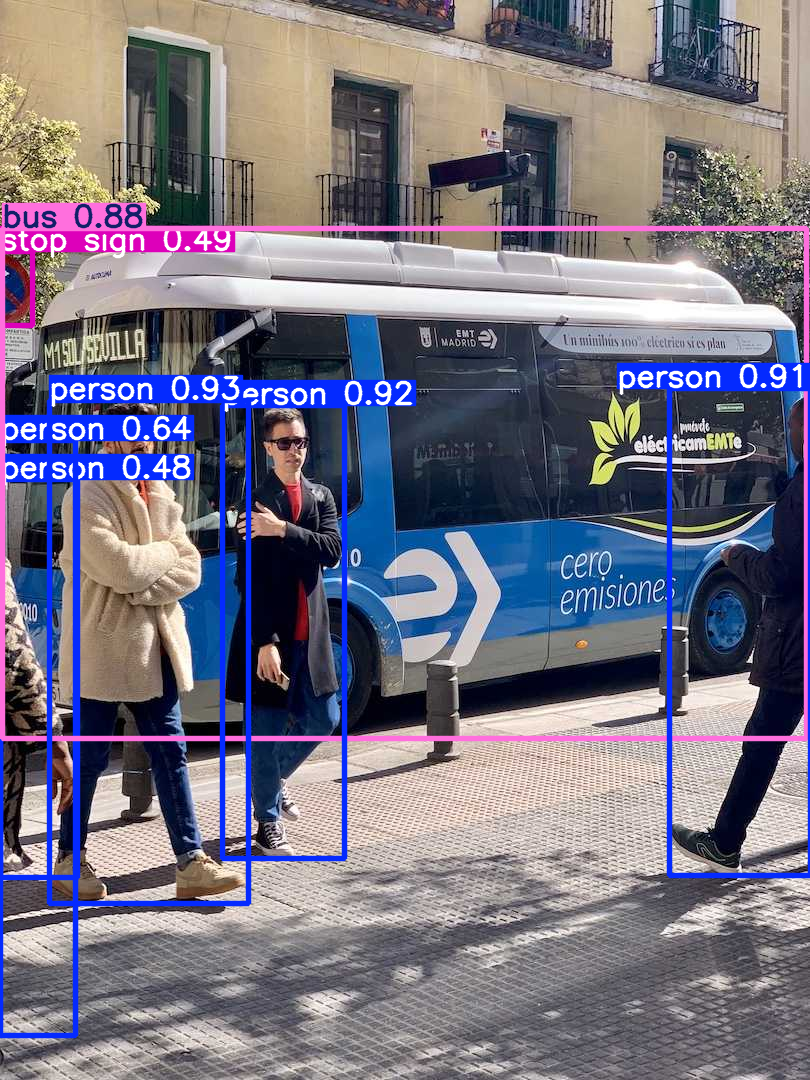

In [ ]:
# Predicting all the default classes
results = model.predict('https://ultralytics.com/images/bus.jpg')
results[0].show()



Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 /content/drive/MyDrive/3DCloudCreationProject/bus.jpg: 640x480 1 bus, 510.2ms
Speed: 4.8ms preprocess, 510.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


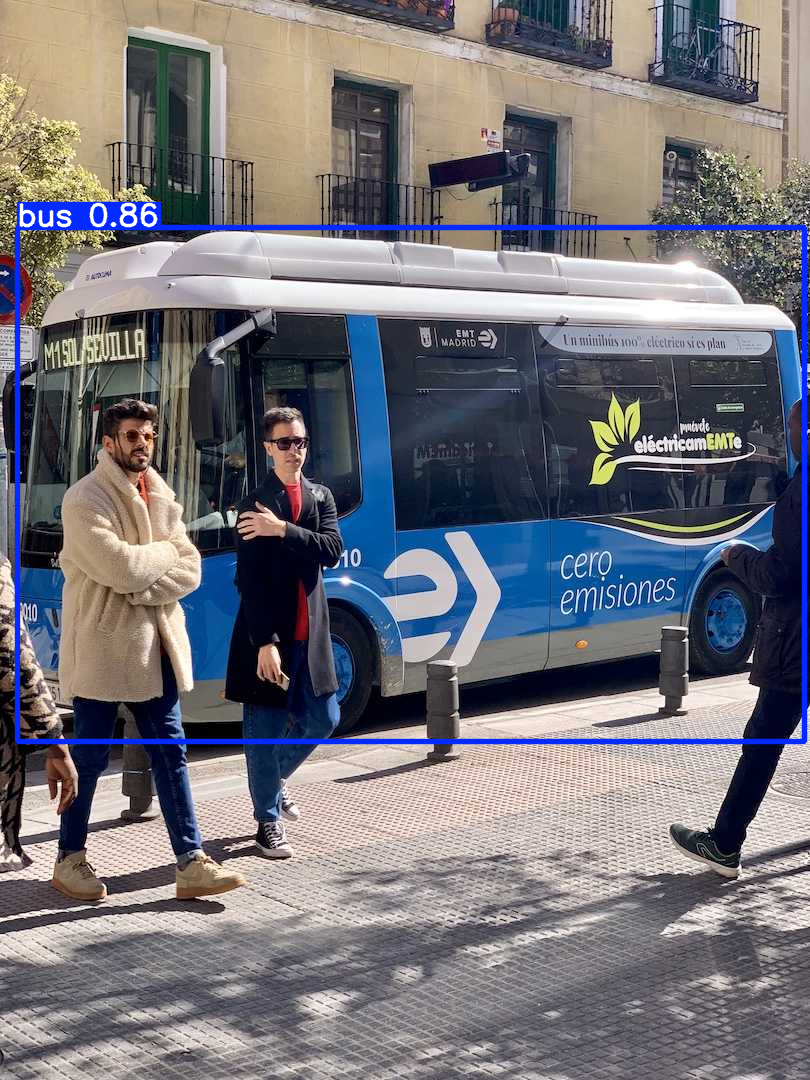

In [ ]:
# Defining specific class of object
model.set_classes(["bus"])
results = model.predict('https://ultralytics.com/images/bus.jpg')
results[0].show()



 Using SAM to mask the selected bounding box by YOLO-world and removing background

In [ ]:
# install SAM
!pip install segment-anything opencv-python matplotlib


In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2025-12-23 17:41:18--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.51, 3.163.189.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  24.8MB/s    in 74s     

2025-12-23 17:42:33 (32.9 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [ ]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from segment_anything import sam_model_registry, SamPredictor
import os
from PIL import Image


Show Sample Image

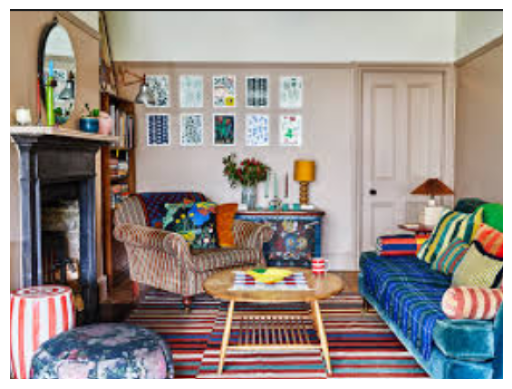

In [ ]:
# Path to the test image
image_path = 'test_imgs/room.png'

# Check if the image file exists
if os.path.isfile(image_path):
    # Load the image
    image = Image.open(image_path)

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()
else:
    print(f"Image not found at {image_path}")



image 1/1 /content/drive/My Drive/3DCloudCreationProject/test_imgs/room.png: 512x640 1 Wooden table, 527.6ms
Speed: 2.7ms preprocess, 527.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


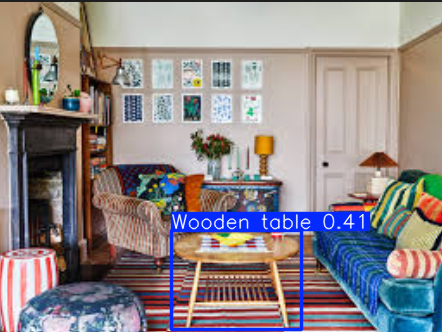

In [ ]:
model.set_classes(["Wooden table"])

results = model.predict(image_path)
r = results[0]
r.show()

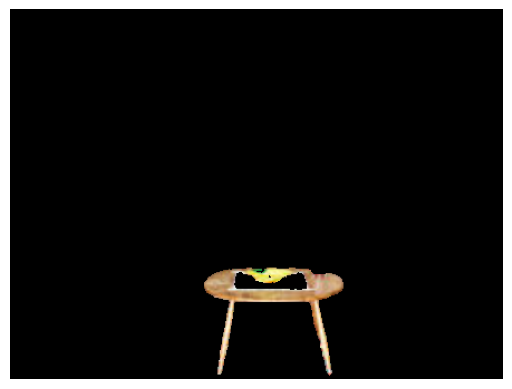

In [ ]:


# Load image
image = cv2.imread(image_path) # Changed from "room.png" to image_path
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get bounding box from YOLO
box = r.boxes.xyxy[0].cpu().numpy()

# Load SAM
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")
sam.to(device)

predictor = SamPredictor(sam)
predictor.set_image(image)

# Predict mask
masks, scores, _ = predictor.predict(
    box=box,
    multimask_output=False
)
mask = masks[0]

# Apply mask
object_only = image.copy()
object_only[~mask] = 0

# Visualize
plt.imshow(object_only)
plt.axis("off")
plt.show()

estimating depth by depth-anything

In [ ]:
DEPTH_REPO_PATH = 'Depth-Anything-V2'

if not os.path.exists(DEPTH_REPO_PATH):
    !git clone https://github.com/DepthAnything/Depth-Anything-V2.git
else:
    print("Depth-Anything-V2 repo already exists, skipping download.")


Depth-Anything-V2 repo already exists, skipping download.


In [ ]:

sys.path.append(DEPTH_REPO_PATH)

from depth_anything_v2.dpt import DepthAnythingV2

In [ ]:
# Load Depth-Anything-v2 Model

model = DepthAnythingV2(
    encoder="vits",
    features=64,
    out_channels=[48, 96, 192, 384]
)

checkpoint_path = "Depth-Anything-V2/checkpoints/depth_anything_v2_vits.pth"

model.load_state_dict(
    torch.load(checkpoint_path, map_location=device)
)

model.to(device).eval()

print("Depth-Anything-V2 loaded successfully")


Depth-Anything-V2 loaded successfully


In [ ]:
# Now we've used metric depth on full image.
# Now We'll generate 3D cloud.



In [ ]:
rgb = cv2.imread(image_path)

rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

with torch.no_grad():
    depth = model.infer_image(rgb)

print(depth.shape, depth.min(), depth.max())

# save output
depth_img_path = "output/room_depth.png"

plt.imsave(depth_img_path, depth, cmap="inferno")



(332, 442) 0.4410291 6.558871


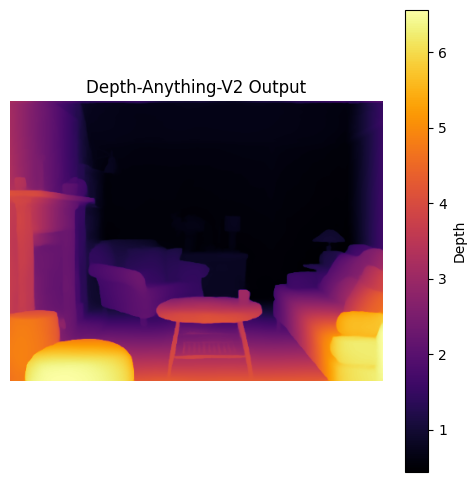

In [ ]:
plt.figure(figsize=(6, 6))
plt.imshow(depth, cmap="inferno")
plt.colorbar(label="Depth")
plt.axis("off")
plt.title("Depth-Anything-V2 Output")
plt.show()


Generate 3D cloud

In [ ]:
# Edge-preserving smoothing before 3D projection
depth_smooth = cv2.bilateralFilter(
    depth.astype(np.float32),
    d=7,
    sigmaColor=0.1,
    sigmaSpace=5
)

In [ ]:
masked_depth = depth.copy()
masked_depth[~mask] = 0.0


In [ ]:
z = points[:,2]
z_mean, z_std = z.mean(), z.std()

inliers = (z > z_mean - 2*z_std) & (z < z_mean + 2*z_std)

points = points[inliers]
colors = colors[inliers]
step = 2  # try 2 or 3
points = points[::step]
colors = colors[::step]



NameError: name 'points' is not defined

In [ ]:
H, W = depth.shape
fx = fy = 500.0
cx = W / 2.0
cy = H / 2.0


In [ ]:
u, v = np.meshgrid(np.arange(W), np.arange(H))

Z = masked_depth
valid = Z > 0

X = (u - cx) * Z / fx
Y = (v - cy) * Z / fy

points = np.stack((X[valid], Y[valid], Z[valid]), axis=-1)
colors = image[valid] / 255.0


In [ ]:
import plotly.graph_objects as go

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=points[:,0],
            y=points[:,1],
            z=points[:,2],
            mode="markers",
            marker=dict(
                size=2,
                color=colors
            )
        )
    ]
)

fig.update_layout(
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z (meters)"
    ),
    title="Object-only 3D Point Cloud (YOLO + SAM + Depth-Anything)",
    width=800,
    height=800
)
fig.write_html(
    "/content/drive/MyDrive/3DCloudCreationProject/output/object_3d_cloud.html"
)

fig.show()


In [ ]:
!pip install open3d


In [ ]:
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.5 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
import open3d as o3d
import numpy as np

# points: (N,3) numpy array
# colors: (N,3) numpy array in [0,1]

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)
o3d.io.write_point_cloud("output/object_3d_cloud.ply", pcd)
print("Saved object_3d_cloud.ply")


NameError: name 'points' is not defined

In [ ]:
o3d.visualization.draw_plotly([pcd])
